# IT Security - Sheet 6 "Security of Classical Applications"

**Total achievable points: 20**

**Released: 09.01.2025**

**Submission Deadline: 16.01.2024**

---
Group: 128

Names and matriculation numbers of **ALL** team members: Samuel Rode (445160), Nils Maasch (445796), Pau Azpeita Bergos (443428), Gereon Geuchen (445328), Ben-Jay Huckebrink (445219)

---

**Important Information**

The assignments have to be submitted by groups of 5 students. Even if you are registered in RWTHmoodle to a submission group, **please include the group number as well as the name and matriculation number of every group member in this notebook**. In case you are not part of a submission group and want to hand in assignments, please contact `ba-itsec@itsec.rwth-aachen.de`. We will then assign you to a submission group.

Enter your solutions for the tasks in the respective cells of this notebook. These cells are either marked by "YOUR ANSWER HERE" or `#YOUR CODE HERE`. In code cells, you have to remove `raise NotImplementedError()`. Please do not add any new cells or remove existing ones, especially do not copy cells. Cells marked with `###PLAYGROUND` can be used to test your implementation and generate output (see example for the first tasks). Please do not add any other output or tests in the cell of the task, just implement the function with the header provided. If you want to test your implementation, use the `###PLAYGROUND` cells. They will be ignored during grading. **Do not change any other cells or add new ones.**

Please **do not import any further Python packages** except the default Python ones and the ones that are explicitly given by us or listed below.

**In this exercise additional packages are needed.** Please make sure that these packages are availabe in the environment the notebook is running in.
- You need `scapy` as in the last exercise.
- You will need the package `pandas`. This is a common package to work with large structured data like tables. It can be installed using `pip install pandas`.
- One package is called `sklearn` / `scikit-learn` ([Documentation](https://scikit-learn.org/stable/install.html)) and provides an easy interface for various ML tasks. The linked page provides information about the installation process.

Please make sure to install all the packages in the same environment as your jupyter notebook (`ipykernel`).

*Hint: Reading documentation of modules is fun, fun, fun.*

## Content of this Assignment

In the lecture, you learned about a few "classical applications" and their security, namely E-Mail, DNS and SSH. In this assignment, we will play around with some of these topics. First, we have a look at DNS and DNSSec and you will pay special attention to the trust of chain there. Afterwards, we will have a look at e-mail security, especially PGP and the Web-of-Trust. The last programming task deals with a spam detector for emails that you will implement. For this, we introduce the functionality of a naive Bayes spam filter.

## 1. DNS and DNSSec (6 points)

For this task, we provided a pcap file. This file contains a DNS Query and all belonging requests necessary to validate the authenticity of this resource record using DNSSEC. As in the last assignment, it is necessary to read in the pcap file first. This is done in the following cell using the package scapy.

**Please make sure that the file `dns.pcap` from moodle is present in the same directory as this notebook.**

In [ ]:
### You don't have to implement something here!

from scapy.all import *
load_layer("tls")

def read_pcap(path_name: str) -> list[Packet]:
    return rdpcap(path_name)

packets_dns = read_pcap("./dnssec-dns.pcap")

The following tasks will work with this recorded transmission.

### Task 1.1 (1.5 points)

First, we have to find packets with messages we are interested in. For this, we have to look into the messages recorded.

A typical DNS request consists of a packet sent to a DNS server containing the query and the answer message contains the query again and one or more answers to this query. In the following, we will first check if a packet contains just the query or also answers. Afterwards we want to iterate over the answers and want to determine the type of the resource record this answer contains. For this, you have to implement three different functions:

- The first one is `contains_answer(packet: scapy.packet.Packet) -> bool` which takes a packet and checks if it contains a DNS message and if the answer section is not empty. The function should return a `bool` which evaluates to `True` if the message contains at least one answer in an DNS message.

- The second function `type_of_RR(rr: scapy.packet.Packet) -> str` takes a resource record (don't get confused here, with scapy everything inherits from a `Packet`) and returns a string (`str`) representing the resource record type. For this task, the different strings of types of resource records are: `A`, `AAAA`, `DNSKEY`, `DS`, `RRSIG`. Should be there other resource record types, you can safely ignore them.

- The third function `types_of_all_RR(packet: scapy.packet.Packet) -> list[str]` is a helper. It will get a packet with a DNS answer with possibly more than one resource record. This function should use the given `get_all_RR(packet: Packet) -> list[scapy.packet.Packet]` function to extract a list with the different resource records and should use the function `type_of_RR(rr: scapy.packet.Packet) -> str` to determine the type of each. At the end, a list with strings should be returned containing the resource record types in the answer in the correct order.
It happens that there are multiple resource records of the same type. In this case, the list should contain multiple times the same entry.

*Hint: Have a look at the documentation of scapy of the DNS layer [here](https://scapy.readthedocs.io/en/latest/api/scapy.layers.dns.html). For most of the mentioned RR types, scapy has classes to represent them. If there is no special class, the corresponding types are handled in `DNSRR` and you have to check the `type` which is an int indicating the type. Maybe you want to have a look [here](https://en.wikipedia.org/wiki/List_of_DNS_record_types).*

In [ ]:
### You don't have to implement something here!

# This function gets a DNS message within a packet and returns a list of all resource records contained in the answer section of the message. If there is no DNS message or the answer section is empty, an empty list will be returned.
# HINT: in scapy everything inherits from scapy.packet.Packet. Don't get confused here, it is not a whole packet, it is just what every resource record inherits from!
def get_all_RR(packet: Packet) -> list[scapy.packet.Packet]:
    if packet.haslayer(scapy.layers.dns.DNS):
        return packet[scapy.layers.dns.DNS].an
    else:
        return []

In [ ]:
def contains_answer(packet: scapy.packet.Packet) -> bool:
    if not (DNS in packet):
        return False
    
    return packet[DNS].ancount != 0

def type_of_RR(rr: scapy.packet.Packet) -> str:
    match rr.type:
        case 1:
            return "A"
        case 28:
            return "AAAA"
        case 48:
            return "DNSKEY"
        case 43:
            return "DS"
        case 46:
            return "RRSIG"

def types_of_all_RR(packet: scapy.packet.Packet) -> list[str]:
    res: list[str] = []
    all_answers = get_all_RR(packet)

    for ans in all_answers:
        if type_of_RR(ans) != "":
            res.append(type_of_RR(ans))
    
    return res

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.

for packet in packets_dns:
    if packet[DNS].ancount != 0:
        for ans in packet[DNS].an:
            print(f"Ans. type: {ans.type}")
        print("-" * 10)
    # print(ls(packet[DNS]))
    # print("-" * 20)

You can use the cell provided below to get more insight into the DNS query done in the network trace.

In [ ]:
### You don't have to implement something here!

for i, packet in enumerate(packets_dns):
    if contains_answer(packet):
        print(f"Packet: {i+1}: contains answers: {types_of_all_RR(packet)}")
    else:
        print(f"Packet: {i+1} does not contain answer.")

In [ ]:
# This test just checks the output of your solution

packet = packets_dns[1]

assert type(contains_answer(packet)) == bool
res = types_of_all_RR(packet)
assert type(res) == list
assert len(res) == 2
assert type(res[0]) == str

In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 1.2 (0.5 points)

In this task, we want to know something about the request and extract some information to display them. So we need to implement a few functions to extract the wanted information. These functions can be used in task 1.3 if needed.

All the functions to be implemented get a resource record (of different types). Don't be confused by the type hint of the first function. Remember, this function fits to different resource record types and everything in scapy inherits from `Packet`.

Implement the following functions:

- `get_name(rr: scapy.packet.Packet) -> str`: This function gets a resource record and should return the corresponding name for this resource record.
- `get_rrsig(rr: scapy.layers.dns.DNSRRRSIG) -> str`: This function gets a RRSIG resource record and should return the signature contained in it **as a hex string**.
- `get_dnskey(rr: scapy.layers.dns.DNSRRDNSKEY) -> str`: This function gets a DNSKEY resource record and should return the public key contained in it **as a hex string**.
- `get_ds(rr: scapy.layers.dns.DNSRRDS) -> str`:  This function gets a DS resource record and should return the hash / digest contained in it **as a hex string**.

*Hint: Have a look at the documentation again to check which parameters are available. Use the provided playground to check if the output is plausible.*

In [ ]:
def get_name(rr: scapy.packet.Packet) -> str:
    return rr.rrname.decode('ascii')
    
def get_rrsig(rr: scapy.layers.dns.DNSRRRSIG) -> str:
    res = "0x"
    for byte in rr.signature:
        res += hex(byte)[2:]
    return res
    
def get_dnskey(rr: scapy.layers.dns.DNSRRDNSKEY) -> str:
    res = "0x"
    for byte in rr.publickey:
        res += hex(byte)[2:]
    return res
    
def get_ds(rr: scapy.layers.dns.DNSRRDS) -> str:
    res = "0x"
    for byte in rr.digest:
        res += hex(byte)[2:]
    return res

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.
for packet in packets_dns:
    rrs = get_all_RR(packet)
    for rr in rrs:
        print(get_name(rr))

The cell below can be used to output all the extracted information using the functions implemented in this task. The output of longer text is truncated.

In [ ]:
### You don't have to implement something here!

for i, packet in enumerate(packets_dns):
    print(f"Packet {i+1}:")
    rrs = get_all_RR(packet)
    for rr in rrs:
        match type_of_RR(rr):
            case "A":
                print(f"A: {get_name(rr)}")
            case "AAAA":
                print(f"AAAA: {get_name(rr)}")
            case "DNSKEY":
                print(f"DNSKEY: {get_dnskey(rr):.50}...")
                print(f"for zone: {get_name(rr)}")
            case "DS":
                print(f"DS: {get_ds(rr):.50}...")
                print(f"for zone: {get_name(rr)}")
            case "RRSIG":
                print(f"RRSIG: {get_rrsig(rr):.50}...")
    print()

In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 1.3 (3 points)

We now know roughly the most important content of each of the DNS packets. Now, we want to have a look at the DNSSEC specific chain of trust. In the following task we assume that all RRSIG signatures are valid and we do not validate them. Instead, we will focus on the DNSKEY and DS RRs.

As we only have a trusted DNSKEY of the root zone `.` in our local storage, we have to build a chain of trust to verify the DNSKEY that was used to sign our initial request. To do so, we have to use the DS RRs and the DNSKEY RRs in combination to verify they build a chain. As you can see, some of the messages contain multiple DNSKEY RRs, which contain at least the zone signing key and the key signing key. Have a look at the lecture slides again if you can't remember the different the purpose of each of the keys. Also, remember that a signature validation would be of course necessary to really ensure the chain is trusted.

- There are two handy functions given in the code block blow. The first function `check_ds_hash(dnskey_rr: scapy.layers.dns.DNSRRDNSKEY, ds_rr: scapy.layers.dns.DNSRRDS) -> bool` validates a given DNSKEY with a given DS RR.

- The second function `get_all_keys_and_ds(packets) -> tuple[dict[str, scapy.layers.dns.DNSRRDS], dict[str, list[scapy.layers.dns.DNSRRDNSKEY]]]` extracts from a given packet list all the different DS RRs and DNSKEY RRs into two convenient dicts. This is useful during the validation. The first returned dict contains the DS RR for the zone (zone name is the key). The second one contains a list of all DNSKEY RRs of a zone. You can use the zone name as the key to the dict to get the corresponinding DS RR and all DNSKEY RRs. Don't be confused with the location of a DS RR. It is physically located at the parent zone, but the query asks for the DS RR for the meant zone, so the DS RR that verifies the zone a.com. can be found in the dict using the key `a.com.`. Also make sure to don't forget the last point of the name.

Your task is now to implement the function `verify_chain(packets: scapy.plist.PacketList, domain: str) -> bool`. This function takes the list of packets as given at the beginning of the task and a domain. The function needs to check if there is a valid chain of trust from the root zone to the given domain. You don't have to validate RRSIG and you can use the given functions explained above to check if a DS RR contains the hash of a DNSKEY RR. It is okay, if the function just checks if the DS RRs hash fits to any of the DNSKEY RRs. You don't have to compute the key tag / key id! The function should return a `bool` that evaluated to `True` if there is a chain of trust from the root to the given domain. If there is a zone without a fitting DNSKEY to the provided DS RR, then your function should return `False`.

*Hint: Try to iterate over all zones of the given domain, search for corresponding DS RR and check if there is a fitting key. If there is a zone without a DS record or if there is no fitting key, the validation failed.*

In [ ]:
### You don't have to implement something here!

import hashlib

# This function validates a given DNSKEY RR with another given DS RR
def check_ds_hash(dnskey_rr: scapy.layers.dns.DNSRRDNSKEY, ds_rr: scapy.layers.dns.DNSRRDS) -> bool:
    
    # Extract fields from the DNSKEY RR
    ## Owner name (domain) in wire format
    labels = dnskey_rr.rrname.decode().strip('.').split('.')
    wire_format = b''.join(len(label).to_bytes(1, 'big') + label.encode() for label in labels)
    owner_name = wire_format + b'\x00'

    ## rdata of DNSKEY record
    flags = dnskey_rr.flags.value.to_bytes(2, byteorder='big') # First 2 bytes are the flags
    protocol = dnskey_rr.protocol.to_bytes(1, byteorder='big')  # Next byte is the protocol
    algorithm = dnskey_rr.algorithm.to_bytes(1, byteorder='big')  # Next byte is the algorithm
    public_key = dnskey_rr.publickey  # Rest is the public key

    # Construct byte string to be hashed
    dnskey_data = owner_name + flags + protocol + algorithm + public_key

    # Compute hash
    hasher = hashlib.sha256()
    hasher.update(dnskey_data)
    key_hash = hasher.hexdigest()

    ds_hash = get_ds(ds_rr)
    return key_hash.upper() == ds_hash.upper()

# This function extracts all DS RRs and DNSKEY RRs into two convenient dicts sorted by their names. This will be very helpful!
def get_all_keys_and_ds(packets) -> tuple[dict[str, scapy.layers.dns.DNSRRDS], dict[str, list[scapy.layers.dns.DNSRRDNSKEY]]]:
    dss = {}
    keys = {}
    for i, packet in enumerate(packets):
        if contains_answer(packet):
            rrs = get_all_RR(packet)
            for rr in rrs:
                if type_of_RR(rr) == "DS":
                    zone_name = get_name(rr)
                    if type(zone_name) == bytes:
                        zone_name = zone_name.decode()
                    if zone_name not in dss:
                        dss[zone_name] = rr
                elif type_of_RR(rr) == "DNSKEY":
                    zone_name = get_name(rr)
                    if type(zone_name) == bytes:
                        zone_name = zone_name.decode()
                    if zone_name not in keys:
                        keys[zone_name] = []
                    keys[zone_name].append(rr)
    return (dss, keys)
    

In [ ]:
def verify_chain(packets: scapy.plist.PacketList, domain: str) -> bool:
    zones: list[str] = list(reversed(domain.strip('.').split('.')))
    ds_rrs, dnskey_rrs = get_all_keys_and_ds(packets)

    print(ds_rrs)
    print(dnskey_rrs)

    for i in range(len(zones) + 1):
        if i == 0:
            continue

        zone_name = ""
        for j in range(i):
            zone_name += zones[j] + "."
        if i == 0:
            zone_name += "."

        print(f"Checking zone {zone_name}")

        ds_key = ds_rrs.get(zone_name, None)
        if ds_key is None:
            return False

        matching_pair_found: bool = False
        for dnskey_rr in dnskey_rrs[zone_name]:
            matching_pair_found |= check_ds_hash(dnskey_rr, ds_key)

        if not matching_pair_found:
            return False

    return True

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.

You can use the cell below to check the validation result and inspect any additional output.

In [ ]:
### You don't have to implement something here!

print(verify_chain(packets_dns, 'dnssec.works.'))

In [ ]:
# This test just checks the output of your solution

res = verify_chain(packets_dns, 'dnssec.works.')
assert type(res) == bool
assert res == True

In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 1.4 (1 point)

**Name or describe** the purpose of each of the resource record types `A`, `RRSig`, `DNSKEY`, `DS`.

- `A` is just the regular IPv4 DNS RR (= "translation" domain name -> IPv4 address)
- `RRSig` is associated with another RR (let's call it 'x') & used to _sign_ 'x' (i.e., the `RRSig` contains the _signature_ created on 'x' using the _zone signing key_ [ZSK] of the corresponding zone)
- `DNSKEY` contains either a KSK or a ZSK
- `DS` contains the hash of the key signing key [KSK] of a child zone

## 2. PGP and S/MIME (5 points)

### Task 2.1: PGP - Web of Trust (2 points)

PGP uses a "web of trust" instead of certification authority to assess the trust of a key. To do so, the "key legitimacy" of a party is calculated as described in the lecture. 

Your task here is to implement the function `calc_key_legitimacy(trust_levels: list[tuple[str, str]], x: float, y: float) -> int` which receives a list of tuples `trust_levels`. Each tuple of the list contains a `str` with the name of the party and a `str` with the name of the trust levels. 

Possible trust levels are `"no"`, `"unknown"`, `"partial"`, and `"full"`. Hence, a tuple in the list could look like: `("NSA", "no")`. The floats `x`/`y` represent the numerical certificate trust value we assign to certificates with the trust level `partial`/`full`.

Your function should return the certificate trust value as `int`.

In [14]:
def calc_key_legitimacy(trust_levels: list[tuple[str, str]], x: float, y: float) -> int:
    N_x: int = 0
    N_y: int = 0

    for _, trust_lvl in trust_levels:
        if trust_lvl == "partial":
            N_x += 1
        elif trust_lvl == "full":
            N_y += 1

    if (x * N_x + y * N_y) >= 1:
        return 1
    return 0

In [15]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.

trust_levels_test1 = [("Simon", "partial"), ("Andrew", "no"), ("Louis", "unknown"), ("Casper", "full"), ("Lilly", "no"), ("Rebecca", "unknown")]
print(calc_key_legitimacy(trust_levels_test1, 0.2, 0.5))

0


In [16]:
# This test just checks the output of your solution

trust_levels_test2 = [("Simon", "partial"), ("Andrew", "no"), ("Louis", "unknown"), ("Casper", "full"), ("Lilly", "no"), ("Rebecca", "partial")]
res = calc_key_legitimacy(trust_levels_test2, 0.3, 0.5)
assert type(res) == int
assert res == 1


In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 2.2: TLS vs. PGP and S/MIME (2 point)

**Explain** the fundamental difference between the usage of TLS (e.g. with SMTPs or IMAPs) and the usage of PGP or S/MIME during e-mail transfer. Explicitly name who has access to the messages and who is able to modify them.

The **fundamental difference** between TLS & (PGP or S/MIME) is that TLS **only provides security _during transportation_** of the emails _between_ MTAs, but **not** when the emails are _stored_ on the MTAs. This means that **anybody with access to an MTA** our email is stored on can read & modify our email (assuming _no_ further protective measures are taken on the MTAs, i.e., mails are stored in _cleartext_ there).
Additionally, TLS **does not provide** any non-repudiation, as it only provides "hop-by-hop" transport security.

On the other hand, PGP and S/MIME **ensure _end-to-end security_** by providing end-to-end encryption & integrity protection (even when the email is just stored on an MTA server) as well as providing non-repudiation; this means that **only the intended receiver** may _read_ our email (since only they have the matching _private key_ necessary to decrypt the symmetric key $K$ the email was encrypted with). However, due to the signature, **even the intended receiver** is **not able to modify** our email (without it getting noticed because of the signature).

### Task 2.3: PGP vs S/MIME (1 points)

How can one determine if a S/MIME certificate should be trusted?

Since S/MIME just uses "regular certificates" issued by some **certificate authority**, we can just check the "chain of trust" of the certificate like seen in Chapter 5 of the lecture: Check who is the issuer of the certificate, check the signature of the issuer with the public key of the issuer; if that issuer still has a parent certificate, do this check recursively until we reach a root CA. Then, we check whether that root CA is **trusted for providing S/MIME certificates** by checking whether the found root CA belongs to a pre-configured **list of trusted CAs** we configured in the email client (see Chapter 7, slide 10).

## 3. Spam Classifier (Naive Bayes) (8 points)

A widely used spam filter is the "naive Bayes filter". As the name suggest, it is based on the [Bayes theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which states 

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$ for events $A$ and $B$ with $P(B) \neq 0$.

We will use the Bayes theorem to predict the class of an e-mail - either spam or ham.

For an e-mail `m = [w_1, w_2, ... w_n]` given a class `C`, we calculate the probability of `m` being of class `C` (e.g. "ham" or "spam") as follows:

$Pr[C|m] = \frac{Pr[m|C] \cdot Pr[C]}{Pr[m]}$.

In practice, we can further simplify this by dropping the denominator, because for each possible class `C`, $Pr[m]$ is the same, hence we are interested in:

$Pr[m|C] \cdot Pr[C]$

In the **naive** Bayes classifier, we have the assumption that all features $w_i$ are mutually independent (hence the name). With that assumption we can calculate the conditional probability of an e-mail `m` given the class `C` by multiplying the conditional probabilities for each individual word `w` given class `C`:

$Pr[m|C] \cdot Pr[C] = Pr[w_1, w_2,..., w_n|C] \cdot Pr[C] = Pr[w_1|C] \cdot Pr[w_2|C] \cdot \;\; ... \;\; \cdot Pr[w_n|C] \cdot Pr[C]$

Now, we still need to be able to calculate the conditional probability per word which can be done by using a training dataset, as follows.
Given a vocabulary `V` of words from a training dataset: 

$Pr[w|C] = \frac{count(w, C)}{\sum_{w' \in V}count(w',C)}$

However, we may have have zero counts in a class. Hence, we use "add one smoothing" (which is just a fancy name for adding one count for each word) to not lose this information. 

Thus, the conditional probability for one word is calculated as follows:

$Pr[w|C] = \frac{count(w, C) + 1}{\sum_{w' \in V}count(w',C) + |V|}$

In the algorithm, we use log probabilites to prevent a numerical underflow, because multiplying many probabilities will result in 0.0. Note, that adding in log space is equivalent to multiplying in linear space:

$Pr[m|C] = Pr[w_1|C] \cdot Pr[w_2|C] \cdot \;\; ... \;\; \cdot Pr[w_n|C]$ $= exp( log(Pr[w_1|C]) + log(Pr[w_2|C]) + \; ... \;  + log(Pr[w_n|C])$

Your task will be to build a spam classifier based on the naive bayes theorem. To do so, we begin with the training of the model by calculating the probability distributions of each class. 

To start, we load the dataset. You can find the the CSV file containing the dataset in Moodle.

In [1]:
import pandas as pd

orig_df = pd.read_csv("./SPAM_dataset.csv")

In the next step, we tokenize each mail into a list of words, to ease the handling in the later steps. 
However, as you can see there are many special characters that we want to remove.

In [2]:
df = orig_df
df['mails'] = orig_df.apply(lambda row: row['mails'].split(" "), axis=1)
df.head()

,mails,labels
0,"[subject:, hi, paliourg, all, available, meds,...",SPAM
1,"[subject:, home, loans, &, refinancing, at, ve...",SPAM
2,"[subject:, hpl, nom, for, april, 26, ,, 2001\n...",HAM
3,"[subject:, re, :, august, 2000, estimated, ava...",HAM
4,"[subject:, hesco, gathering, company, ,, l, .,...",HAM


In the following, we remove the special characters and so-called stop words (e.g. and, or, me, you).

In [3]:
stopwords = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",
    "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself',
    'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll",
    'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has',
    'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
    'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 
    'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once',
    'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
    'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than',
    'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now',
    'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn',
    "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
    "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't",
    'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]

df['mails'] = df['mails'].apply(lambda x: [word for word in x if word not in stopwords and word.isalpha()])
df = df[df['mails'].map(len) > 0]
df.head()

,mails,labels
0,"[hi, paliourg, available, meds, available, bin...",SPAM
1,"[home, loans, refinancing, low, rates]",SPAM
2,"[hpl, nom, april, see, attached, file, hplno, ...",HAM
3,"[august, estimated, owners, volumes, included,...",HAM
4,"[hesco, gathering, company, l, l, c, meter, du...",HAM


In order to train and test a model, we also have to **split the data into a training and test set**. We choose 20% of the whole dataset to be our test set, a common split value. Note, that usually we also would need a held-out set to finally asses the quality of the selected model chosen from candidates evaluated on the test set. However, we simplify the process here.

In [4]:
from sklearn.model_selection import train_test_split

# split into training and test set
train, test = train_test_split(df, test_size=0.2, random_state=0)

# split into classes AND training and test
ham_train = train.loc[df['labels'] == "HAM"]
spam_train = train.loc[df['labels'] == "SPAM"]

ham_test = test.loc[df['labels'] == "HAM"]
spam_test= test.loc[df['labels'] == "SPAM"]

Furthermore, we will use standard python data structures for this task. We first transform the data sets to lists. Each mail is then represented as a list of words and the datasets are represented as a list of mails. Additionally we store the labels of the test set in order to evaluate our model.

In [5]:
# Lists for training
ham_train_list = list(ham_train["mails"])
spam_train_list = list(spam_train["mails"])

# Lists of the test data sets and the corresponding labels
ham_test_list = list(ham_test["mails"])
spam_test_list = list(spam_test["mails"])
labels = ["HAM"] * len(ham_test_list) + ["SPAM"] * len(spam_test_list)

# the whole training corpus
train_texts = ham_train_list + spam_train_list

### Task 3.1 (1.5 points)

Your first actual task is now to compute the **feature set**. To do so, consider all the words in the training set but make sure they only occur only once. Implement the function `create_vocabulary(dataset)` which expects a list `dataset` (e.g. `train_texts`) and returns a `set`.

In [6]:
def create_vocabulary(dataset) -> set:
    res: set = set()
    for text in dataset:
        for word in text:
            res.add(word)
    
    return res

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.
print(create_vocabulary(train_texts[:10]))

In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

We use those words as features. To calculate the probability distributions for both classes (`'HAM'` and `'SPAM'`) now, we first create two large mails, each representing their respective class, by simply concatenating all mails from the respective class. 

In [7]:
def flatten(texts):
    return [word for text in texts for word in text]

big_ham_mail = flatten(ham_train_list)
big_spam_mail = flatten(spam_train_list)

### Task 3.2 (2.5 points)

On those two large mails, we want to compute the distribution for their classes, respectively. To do so, implement the function `get_log_distribution(mail, vocabulary)` that calculates the log probability (as described above) of each word in the vocabulary for a mail class (SPAM or HAM) and returns a `dictionary` with the format `{word: log_prob}`, given a vocabulary. 

The probability distributions, one for each class, then represent our model. 

Start with an initial count of 1 for each word, to realize add one smoothing.

In [8]:
from math import log

def get_log_distribution(mail: list[str] , vocab: list[str]):
    # Initialize every word in 'vocab' with count of one
    res: dict[str, float] = dict()
    for word in vocab:
        res[word] = 1

    for word in mail:
        res[word] += 1


    # Here, 'res' contains the _count_ of each word in the given mail (+ 1)
    norm_factor: int = len(mail) + len(vocab) # sum_(w' in V) count(w', C) is just len(mail)
    for word in res.keys():
        res[word] = log(res[word]/norm_factor)

    return res

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.


In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 3.3 (4 points)

Finally, we can implement our Bayes classifier. 

Implement the function `predict_bayes(mail, log_ham_distribution, log_spam_distribution)` that predicts the label for a given mail `mail_item`. To do so, add up the log probability for each word in the mail and the prior probability of a class:

$log(Pr[m|C]) + log(Pr[C])$

and return the name of the class (i.e. `"HAM"` or `"SPAM"`) with the highest sum out of all classes. If a word occurs multiple times, add the corresponding probability multiple times to the overall probability.

You see that we also need the priors for each class (`"HAM"` and `"SPAM"`). This can be done by simply using the share of each class in the whole dataset as follows (You can use the given values in your function).

*Hint: The log probability of the prior is only added once.*

In [9]:
prior_ham = len(ham_train) / len(train_texts)
prior_spam = len(spam_train) / len(train_texts)

In [12]:
import math

def predict_bayes(mail, log_ham_distribution: dict[str, float], log_spam_distribution: dict[str, float]) -> str:
    ham_prob: float = 0.
    spam_prob: float = 0.

    for word in mail:
        # Any word not in the vocabulary gets probability 0
        ham_prob += log_ham_distribution.get(word, 0)
        spam_prob += log_spam_distribution.get(word, 0)
    
    ham_prob += log(prior_ham)
    spam_prob += log(prior_spam)

    if ham_prob > spam_prob: # > or >= is a choice
        return "HAM"
    else:
        return "SPAM"

In [ ]:
### PLAYGROUND
# You can use this cell to test out your implementation. Everything in this cell will be ignored during grading.


In [ ]:
# Even this cell seems empty, it contains automatic tests. Please do not remove this cell and just ignore it.

### Task 3.4

If you have done the earlier tasks correctly, you can use this task to visualize the evaluation results of your classifier on the earlier created test set. You do not have to implement anything yourself, this is only for visualization (and fun).

              precision    recall  f1-score   support

         HAM       0.98      0.99      0.98       726
        SPAM       0.97      0.95      0.96       303

    accuracy                           0.98      1029
   macro avg       0.98      0.97      0.97      1029
weighted avg       0.98      0.98      0.98      1029



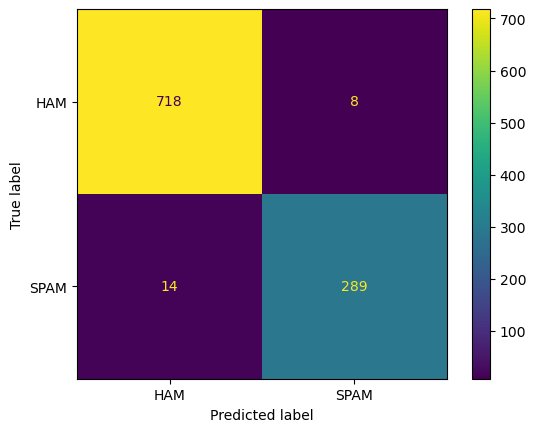

In [13]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

vocab = create_vocabulary(train_texts) # You forgot this one
log_distribution_HAM = get_log_distribution(big_ham_mail, vocab)
log_distribution_SPAM = get_log_distribution(big_spam_mail, vocab)

# Make predictions on the test set
predicted = []
for mail in ham_test_list+spam_test_list:
    if predict_bayes(mail, log_distribution_HAM, log_distribution_SPAM) == "SPAM":
        predicted.append("SPAM")
    else:
        predicted.append("HAM")

# Visualize metrics
cm = confusion_matrix(labels, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["HAM", "SPAM"])
disp.plot()
print(classification_report(labels, predicted))

## 4. Exam Example Tasks (0.5 points)

> Note: This task is awarded with 0.5 points only if it has been seriously addressed, regardless of whether the answer is correct.

### Task 4.1 - PGP

Alice uses PGP and assigns a weight of $\frac{1}{2}$ to fully trusted introducers and a weight of $\frac{1}{3}$ to partially trusted introducers. Alice trusts herself with a weight of 1.

The graph below shows a subset of PGP users. The arrows indicate who has singed whose key, e.g., Alfred has signed Daisy's key. Write for each box the key legitimacy (using the letters A - F) that would be assigned by Alice assuming the weights from above.

![](./pgp.png)

First, for each key certificate, we calculate the trust value (syntax: 'Issuer' -> 'Owner of PK'):
- 'Alice' -> 'A': Trust level 1
- 'Alice' -> 'B': Trust level 1
- 'Alice' -> 'C': Trust level 1
- 'A' -> 'D': Trust level 1/2
- 'C' -> 'D': Trust level 1/2 
- 'C' -> 'E': Trust level 1/2
- 'D' -> 'E': Trust level 0

From this, we can calculate the key legitimacy of key
- A to be 1 (since 1 * 1 >= 1)
- B to be 1 (since 2 * 1/2 >= 1)
- C to be 1 (trivially Alice thinks her own key is legitimate)
- D to be 1 (since 1 * 1 >= 1)
- E to be 1 (since 1 * 1 >= 1)
- F to be 0 (since 1/2 * 1 < 1)

### Task 4.2 - DNSSEC

The user uses DNS queries **without** DNSSEC. Name **two** possible attacks for this scenario.

- **Cache poisoning attack**: A malicious actor attacks a victim NS & poisons its cache with faked RRs by first _requesting_ an RR from the victim NS & then _immediately sending_ a fake RR for the request _back_ to the victim NS
- **Eavesdropping attack**: Since DNS queries are unencrypted, they can be collected by a malicious actor to gain metadata information about us

Now, the user uses DNSSEC. Are the two attacks you named above still possible? If no, **explain** what feature of DNSSEC prevents it. If yes, **propose** a solution to prevent the attack.

- **Cache poisoning** is made **impossible** (due to RRs now needing to be _signed_ by an RRSIG RR, which entails a _chain of trust_ that can be verified & _not faked_ by the malicious actor)
- **Eavesdropping** is **still possible** (integrity protecting DNS RRs != protecting the sender's _queries_ for those RRs; one would need to _use DoT (DNS over TLS)_ to prevent this type of attack)

## 5. Feedback (0.5 points)

> Note: This task is awarded with 0.5 points only if there is feedback in any form to this exercise. It is also okay to state what was especially nice or rewarding. Literally just writing "anything" is not enough. Any feedback will improve the assignments.

You aced one more assignment, you are nearly there! Since we want to know how it went and how we might improve the exercises, we include the following task. Here, you can write constructive feedback! You even get 0.5 points for it if you write anything. But don't worry, we do not grade the content itself!

We have already stated it twice, and we are going to state it a third time: Making us essentially write down documentation of some Python module in Task 1 again is _neither_ fun _nor_ helps create understanding for the lecture's contents. As we already proposed: If the topic does not lend itself well to programming tasks, then _just don't give us programming tasks_ for that topic; rather, just give us _theoretical, written exercises_. You _already did so_ in Task 2, which we find very good: One _small_ programming exercise, accompanied by tasks questioning our understanding, deepening our "how & why" understanding of the lecture's topics, and not just the "what was the algorithm again?" aspect.

Exercise 3 was very fun; also, since we in this group are enrolled in the "Elements of Machine Learning & Data Science" lecture this semester, this was (probably unintentionally) a _great repetition_ of _that_ lecture's content on Natural Language Processing.